In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
sns.set_style("whitegrid")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
gender = pd.read_csv('../input/titanic/gender_submission.csv')
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<AxesSubplot:xlabel='Sex', ylabel='Count'>

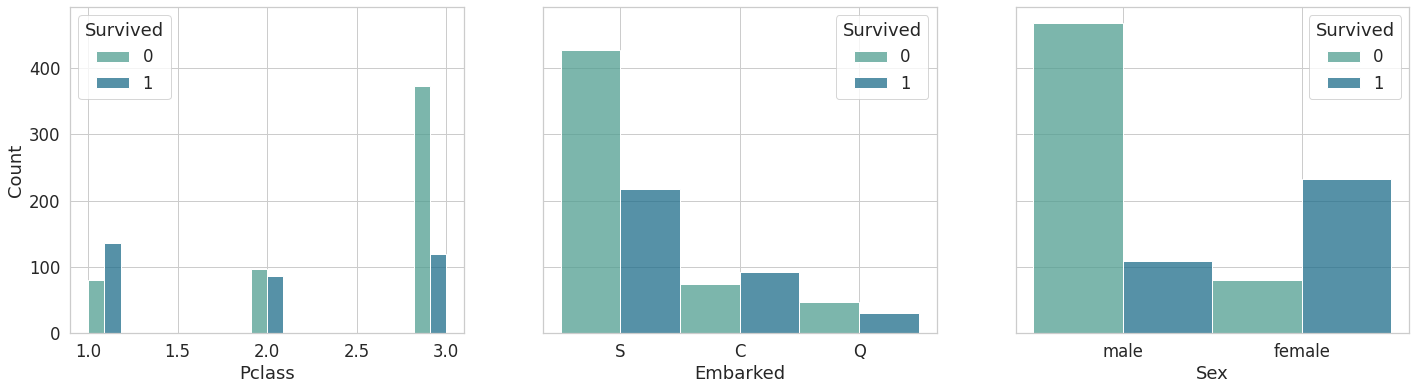

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
sns.histplot(ax=axs[0], data=train, x='Pclass', hue='Survived', multiple="dodge",palette='crest')
sns.histplot(ax=axs[1],data=train, x='Embarked', hue='Survived', multiple="dodge",palette='crest')
sns.histplot(ax=axs[2],data=train, x='Sex', hue='Survived', multiple="dodge",palette='crest')

[Text(0.5, 1.0, 'Sex')]

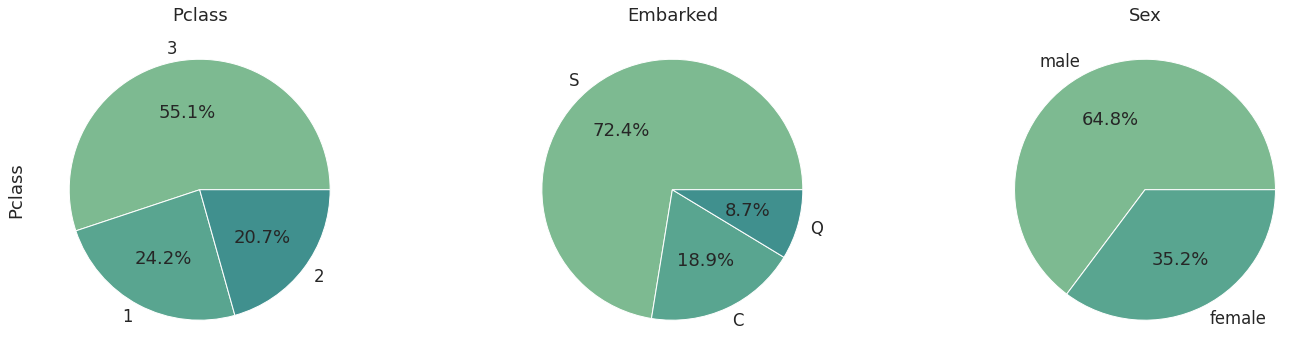

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
train.Pclass.value_counts().plot(ax=axs[0],kind='pie',autopct='%1.1f%%',colors = sns.color_palette('crest')).set(title="Pclass")
train.Embarked.value_counts().plot(ax=axs[1],kind='pie',autopct='%1.1f%%',colors = sns.color_palette('crest')).set(title="Embarked")
train.Sex.value_counts().plot(ax=axs[2],kind='pie',autopct='%1.1f%%',colors = sns.color_palette('crest')).set(title="Sex")

<AxesSubplot:xlabel='Age', ylabel='Count'>

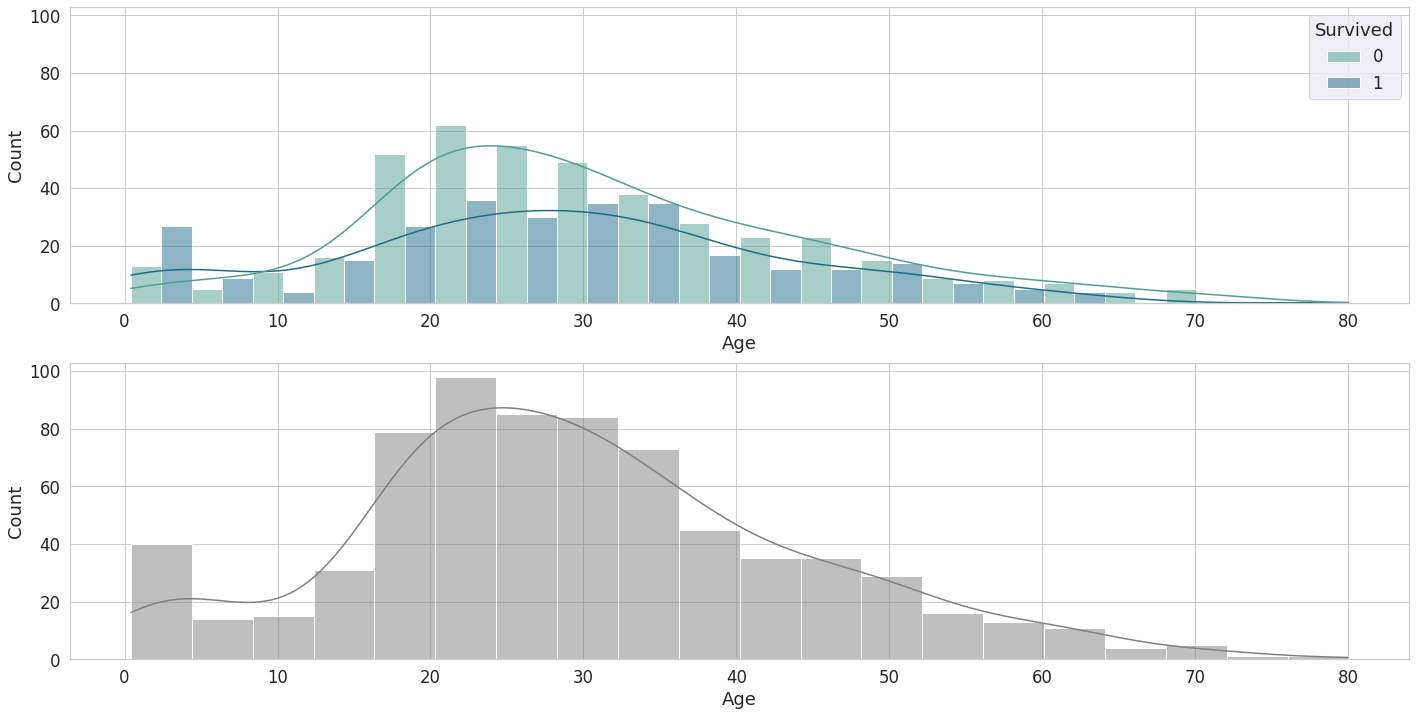

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12), sharey=True)
sns.set(font_scale=1.5)
sns.histplot(ax=axs[0],data=train,hue='Survived' ,x='Age',multiple="dodge", kde=True,palette='crest')
sns.histplot(ax=axs[1],data=train,x='Age',multiple="dodge", kde=True, color='grey')

<AxesSubplot:xlabel='Parch', ylabel='Count'>

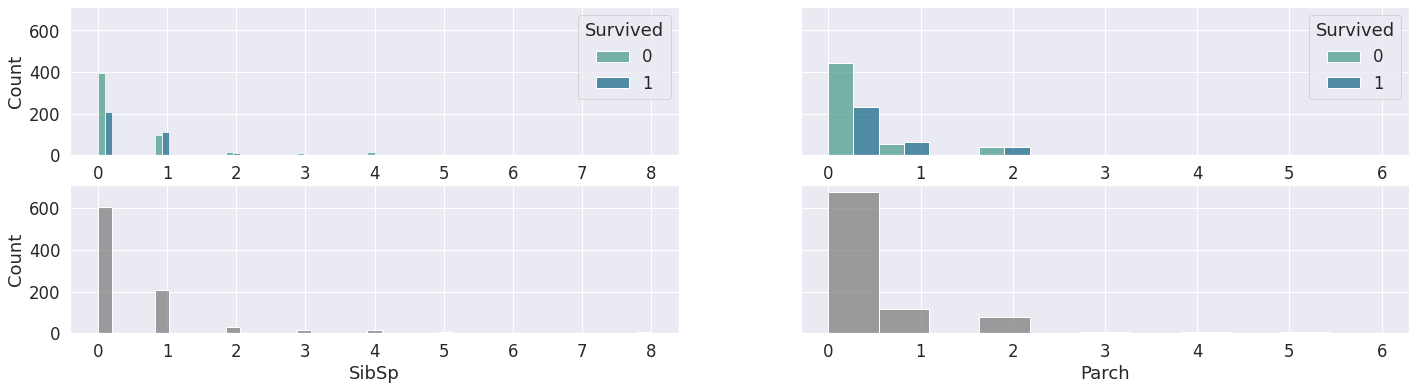

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(24, 6), sharey=True)
sns.histplot(ax=axs[0][0], data=train, x='SibSp', hue='Survived', multiple="dodge",palette='crest')
sns.histplot(ax=axs[0][1],data=train, x='Parch', hue='Survived', multiple="dodge",palette='crest')
sns.histplot(ax=axs[1][0], data=train, x='SibSp', multiple="dodge", color='grey')
sns.histplot(ax=axs[1][1],data=train, x='Parch', multiple="dodge", color='grey')

<AxesSubplot:xlabel='Fare', ylabel='Count'>

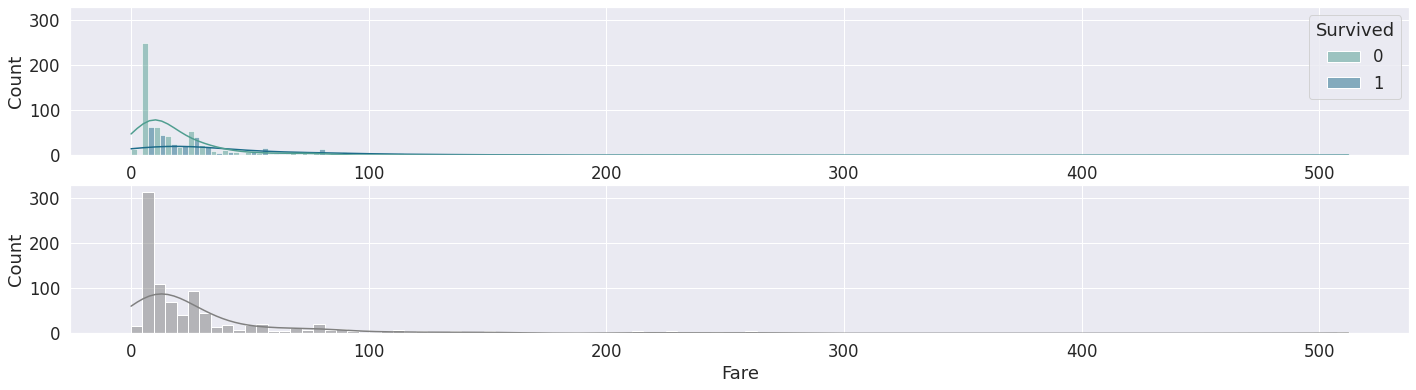

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(24, 6), sharey=True)
sns.set(font_scale=1.5)
sns.histplot(ax=axs[0],data=train,x='Fare',hue='Survived',multiple="dodge", kde=True,palette='crest')
sns.histplot(ax=axs[1],data=train,x='Fare',multiple="dodge", kde=True,color='grey')

In [9]:
df_train_prep = train.drop(["Ticket", "Cabin"], axis=1)
df_test_prep = test.drop(["Ticket", "Cabin"], axis=1)

In [10]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if substring in big_string:
            return substring
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

df_train_prep['Title']=df_train_prep['Name'].map(lambda x: substrings_in_string(x, title_list))
df_test_prep['Title']=df_test_prep['Name'].map(lambda x: substrings_in_string(x, title_list))
 
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
df_train_prep['Title']=df_train_prep.apply(replace_titles, axis=1)
df_test_prep['Title']=df_test_prep.apply(replace_titles, axis=1)

In [11]:
df_train_prep = df_train_prep.drop('Name', axis=1)
df_test_prep = df_test_prep.drop('Name', axis=1)

In [12]:
df_train_prep['Family_size']=df_train_prep['SibSp']+df_train_prep['Parch']
df_test_prep['Family_size']=df_test_prep['SibSp']+df_test_prep['Parch']

<AxesSubplot:xlabel='Family_size', ylabel='Count'>

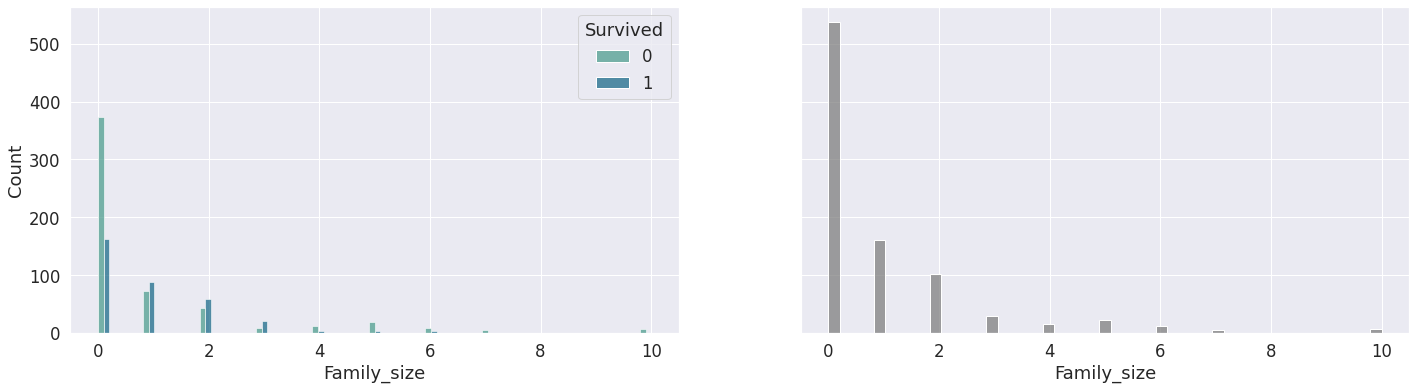

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
sns.histplot(ax=axs[0], data=df_train_prep, x='Family_size', hue='Survived', multiple="dodge",palette='crest')
sns.histplot(ax=axs[1],data=df_train_prep, x='Family_size', multiple="dodge",color='grey')

In [14]:
ac = pd.DataFrame(df_train_prep.groupby(['Pclass', 'Title'])['Age'].median())
ac

Age
Pclass Title       
1      Master   4.0
       Miss    30.0
       Mr      42.0
       Mrs     41.5
2      Master   1.0
       Miss    24.0
       Mr      31.0
       Mrs     31.0
3      Master   4.0
       Miss    18.0
       Mr      26.0
       Mrs     31.0

array([<AxesSubplot:title={'center':'(Age, 1)'}, xlabel='Title'>,
       <AxesSubplot:title={'center':'(Age, 2)'}, xlabel='Title'>,
       <AxesSubplot:title={'center':'(Age, 3)'}, xlabel='Title'>],
      dtype=object)

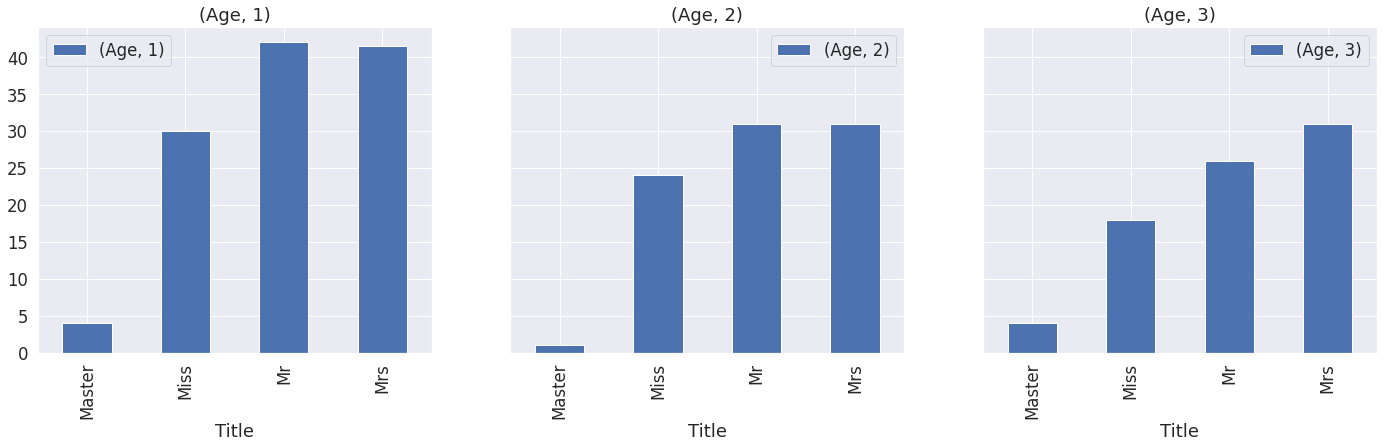

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
ac.unstack(level=0).plot(ax=axs, kind='bar', subplots=True, color="b")

In [16]:
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Master') & (df_train_prep["Pclass"]==1), 'Age'] = 4
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Miss') & (df_train_prep["Pclass"]==1), 'Age'] = 30
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mr') & (df_train_prep["Pclass"]==1), 'Age'] = 42
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mrs') & (df_train_prep["Pclass"]==1), 'Age'] = 42

df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Master') & (df_train_prep["Pclass"]==2), 'Age'] = 1
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Miss') & (df_train_prep["Pclass"]==2), 'Age'] = 24
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mr') & (df_train_prep["Pclass"]==2), 'Age'] = 31
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mrs') & (df_train_prep["Pclass"]==2), 'Age'] = 31

df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Master') & (df_train_prep["Pclass"]==3), 'Age'] = 4
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Miss') & (df_train_prep["Pclass"]==3), 'Age'] = 18
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mr') & (df_train_prep["Pclass"]==3), 'Age'] = 26
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mrs') & (df_train_prep["Pclass"]==3), 'Age'] = 31


df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Master') & (df_test_prep["Pclass"]==1), 'Age'] = 4
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Miss') & (df_test_prep["Pclass"]==1), 'Age'] = 30
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Mr') & (df_test_prep["Pclass"]==1), 'Age'] =  42
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Mrs') & (df_test_prep["Pclass"]==1), 'Age'] = 42

df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Master') & (df_test_prep["Pclass"]==2), 'Age'] = 1
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Miss') & (df_test_prep["Pclass"]==2), 'Age'] = 24
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Mr') & (df_test_prep["Pclass"]==2), 'Age'] = 31
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Mrs') & (df_test_prep["Pclass"]==2), 'Age'] = 31

df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Master') & (df_test_prep["Pclass"]==3), 'Age'] = 4
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Miss') & (df_test_prep["Pclass"]==3), 'Age'] = 18
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Mr') & (df_test_prep["Pclass"]==3), 'Age'] = 26
df_test_prep.loc[(df_test_prep.Age.isnull()) & (df_test_prep["Title"]=='Mrs') & (df_test_prep["Pclass"]==3), 'Age'] = 31


In [17]:
df_test_prep.Fare.fillna(train.groupby("Pclass").median()["Fare"][3], inplace=True)

In [18]:
df_train_prep["Pclass"].replace([1,2,3], [3,2,1], inplace=True)
df_test_prep["Pclass"].replace([1,2,3], [3,2,1], inplace=True)

In [19]:
df_train_prep = pd.get_dummies(df_train_prep, prefix=["Sex", "Embarked", "Title"])
df_test_prep = pd.get_dummies(df_test_prep, prefix=["Sex", "Embarked", "Title"])

In [20]:
X_train = df_train_prep.drop('Survived',axis=1)
y_train = df_train_prep.Survived
X_test = df_test_prep.copy()

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [22]:
clf = SVC().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [23]:
submission = pd.DataFrame({
        "PassengerId": X_test["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('./submission.csv', index=False)